## Study:  Non-Homogeneity of Phase

Now we first generate a phase modulation for duration of 1s, then we evenly slide them into 20 pieces.

#### Warning: It will take a long time to run the following cell, carefully check all data before modifying any parameter of this cell.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from CGH_by_GSA import calculate_mse, plot_frequency_domain, Gaussian_Light, main, signal, spectrum_generation

## Input Parameters

#### Warning: It will take a long time to run the following two cells, carefully modify any parameters and double check before running these cells

In [3]:
T = 0.25
N = 10 ** 6
t = np.linspace(0, T, N)
num_iterations = 2000

# Generate frequency range
w = np.fft.fftfreq(N, t[1]-t[0])

# Define signal in time Domain
signal_out,_ = signal(T, N)

# Define Target Spectrum
amplitude_spectrum_0, phase_spectrum_0 = spectrum_generation(w)

## Execution and Regeneration

In [4]:
t, amplitude_spectrum, phase_spectrum, A_t, phi_t, errors = main(T, N, num_iterations, amplitude_spectrum_0, phase_spectrum_0, signal_out)

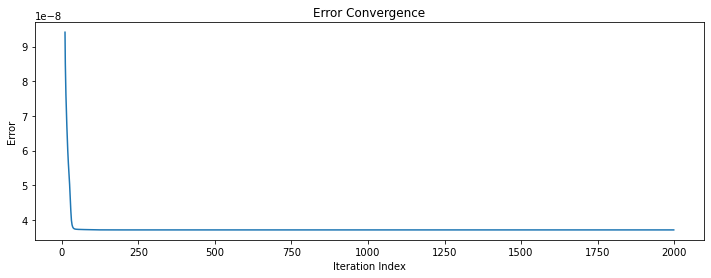

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(list(range(num_iterations))[10:], errors[10:])
plt.xlabel('Iteration Index')
plt.ylabel('Error')
plt.title('Error Convergence')
plt.show()

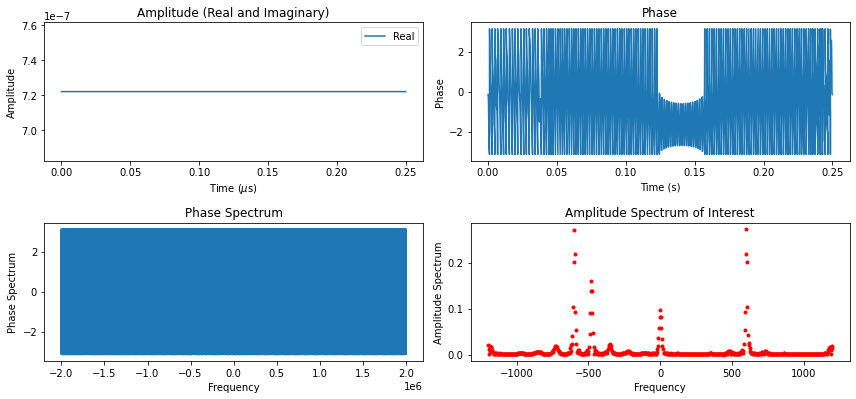

In [6]:
plot_frequency_domain(w, t, A_t, phi_t, amplitude_spectrum, phase_spectrum)

After computation, we slides the  𝜙(𝑡)
  function into 20 pieces. For each pieces, we will regenerate the spectrum from each piece and compute the error.

## Sliding Data

In [7]:
# num_i * c = N

c = 50000
slides = []

for i in range(20):
    a = i * c
    b = (i + 1) * c
    t_ref = t[a:b]
    phi_ref = phi_t[a:b]
    signal_ref = signal_out[a:b]
    slides.append((t_ref, phi_ref, signal_ref))
    i += 1

Check the dimension of output lists

In [8]:
bl = len(slides[0][0]) == c
bl *= len(slides[0][1]) == c
bl *= len(slides[0][2]) == c

print(bl)

1


## Data Analysis Assistance

In [41]:
def data_analysis_slides(slide):
    '''
    Input:
        silde: tuple in list: slides
    Output:
        Error: MSE between the reconstructed spectrum and target spectrum
        Graph_analysis: data that used for further graph analysis, contains frequency and amplitude spectrum
    '''
    
    # Modulated Signal in the Slide of Time
    modulated = slide[2] * slide[1]
    X = np.fft.fft(modulated)
    amplitude = np.abs(X)
    
    dt = slide[0][1]-slide[0][0]
    w = np.fft.fftfreq(len(slide[0]), dt)
    target_spectrum, _ = spectrum_generation(w)
    
    #print(len(w))
    #print(len(target_spectrum))
    #print(len(amplitude))
    
    graph_ana = (w, amplitude, target_spectrum)
    
    error = calculate_mse(amplitude, target_spectrum)

    return error, graph_ana

# Sampling Frequency and Time Duration Study

Now loop over all sildes, compute the error between the regenerated spectrum in each slide and the target spectrum, also plot the spectrums for better visualization.

In [10]:
errors1 = []
graphs = []

for i in range(20):
    error, graph_ana = data_analysis_slides(slides[i])
    errors1.append(error)
    graphs.append(graph_ana)

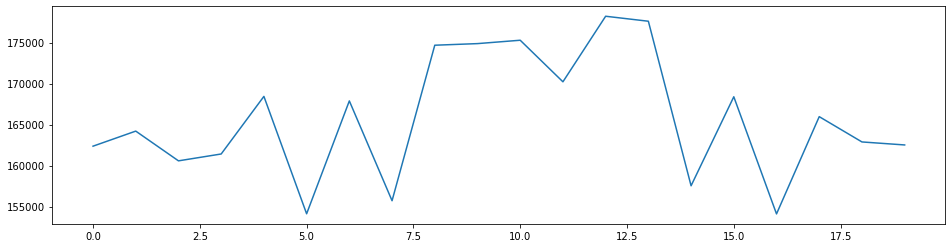

In [11]:
slide_index = list(range(20))

plt.figure(figsize=(16, 4))
plt.plot(slide_index, errors1)

plt.show()

50000


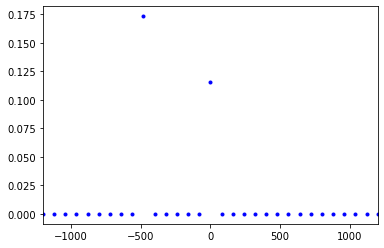

In [12]:
#plt.show(graph_ana[0], graph_ana[1])
print(len(graphs[0][0]))
plt.plot(graphs[0][0], graphs[0][2], 'b.')
plt.xlim([-1200, 1200])

plt.show()

The target spectrum under current resolution is not satisfactory, we are going to study the cause. Actually, the frequency range does not depend on the duration of time but the sampling capability. In last notebook, we apply 10,000 sampling points on a duration of 250 ns, the target spectrum is beautifully shown.

In [60]:
N_test0 = 10000
T_test0 = 0.25
N_test1 = 10 ** 5
T_test1 = 0.25
t_test0 = np.linspace(0, T_test0, N_test0)
t_test1 = np.linspace(0, T_test1, N_test1)

dt_test0 = t_test0[1] - t_test0[0]
dt_test1 = t_test1[1] - t_test1[0]
w_test0 = np.fft.fftfreq(N_test0, dt_test0)
w_test1 = np.fft.fftfreq(500, dt_test1)

In [61]:
print(dt_test0)
print(dt_test1)
print(w_test1[1] - w_test1[0])

2.5002500250025003e-05
2.500000250000025e-08
79999.992


So the low resolution of target spectrum is constrained by both time duration and sampling frequency.If the sampling frequency is too high, the resulting spectrum will have extremely low resolution, while low sampling sampling frequency leads to large time interval in sildes, which also constrains the slide analysis.

Here we see that the phase distribution is highly uneven, and the difference between slides is not significant.But the graph shows that slides in the middle performs better reconstruction. But when we reconstruct the target spectrum, we found that this analysis is not very convincable due to the low resolution of target spectrum. Now we try to take a longer time span, concatenates the slides in the middle. We pick slides index between 9 and 12 (inclusive).

In [62]:
a = 9 * c
b = 12 * c

t_ref = t[a:b]
phi_ref = phi_t[a:b]
signal_ref = signal_out[a:b]

slide_0 = (t_ref, phi_ref, signal_ref)

In [14]:
error, graph_ana = data_analysis_slides(slide_0)

In [15]:
w1, amplitude1, target = graph_ana

Text(0.5, 1.0, 'Amplitude Spectrum')

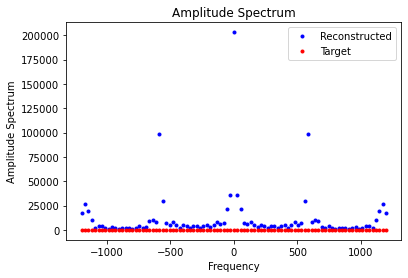

In [16]:
freq_range = (-1200, 1200)
freq_mask = np.logical_and(w1 >= freq_range[0], w1 <= freq_range[1])

plt.plot(w1[freq_mask], amplitude1[freq_mask], 'b.', label = "Reconstructed")
plt.plot(w1[freq_mask], target[freq_mask], 'r.', label = "Target")
plt.xlabel('Frequency')
plt.ylabel('Amplitude Spectrum')
plt.legend()
plt.title('Amplitude Spectrum')

So sliding by time would not yield better reconstruction. Now we need to research another topic: whether the reconstructed signal generate one of the four frequency in a slide? To verify our guess, four target spectrum are used. 

In [17]:
def target_1(freqs):
    Phase = np.zeros(len(freqs))
    Amplitude = np.zeros(len(freqs))
    Signal_w = [Amplitude[i] * np.exp(1j * Phase[i]) for i in range(len(freqs))]
    
    Amplitude = 0.4 * Gaussian_Light(0, 6, freqs)
    c = [Amplitude[i] * np.exp(1j * Phase[i]) for i in range(len(freqs))]
    return np.abs(c)

def target_2(freqs):
    Phase = np.zeros(len(freqs))
    Amplitude = np.zeros(len(freqs))
    Signal_w = [Amplitude[i] * np.exp(1j * Phase[i]) for i in range(len(freqs))]
    
    Amplitude = Gaussian_Light(600, 6, freqs)
    c = [Amplitude[i] * np.exp(1j * Phase[i]) for i in range(len(freqs))]
    return np.abs(c)

def target_3(freqs):
    Phase = np.zeros(len(freqs))
    Amplitude = np.zeros(len(freqs))
    Signal_w = [Amplitude[i] * np.exp(1j * Phase[i]) for i in range(len(freqs))]
    
    Amplitude = Gaussian_Light(-600, 6, freqs)
    c = [Amplitude[i] * np.exp(1j * Phase[i]) for i in range(len(freqs))]
    return np.abs(c)

def target_4(freqs):
    Phase = np.zeros(len(freqs))
    Amplitude = np.zeros(len(freqs))
    Signal_w = [Amplitude[i] * np.exp(1j * Phase[i]) for i in range(len(freqs))]
    
    Amplitude = 0.6 * Gaussian_Light(-480, 6, freqs)
    c = [Amplitude[i] * np.exp(1j * Phase[i]) for i in range(len(freqs))]
    return np.abs(c)

In [63]:
def data_analysis_slides_1(slide):
    '''
    Input:
        silde: tuple in list: slides
    Output:
        Error: MSE between the reconstructed spectrum and target spectrum
        Graph_analysis: data that used for further graph analysis, contains frequency and amplitude spectrum
    '''
    
    # Modulated Signal in the Slide of Time
    modulated = slide[2] * slide[1]
    X = np.fft.fft(modulated)
    amplitude = np.abs(X)
    
    dt = slide[0][1]-slide[0][0]
    w = np.fft.fftfreq(len(slide[0]), dt)
    
    target1 = target_1(w)
    target2 = target_2(w)
    target3 = target_3(w)
    target4 = target_4(w)
    
    graph_ana = (w, amplitude, target1, target2, target3, target4)
    
    error1 = calculate_mse(amplitude, target1)
    error2 = calculate_mse(amplitude, target2)
    error3 = calculate_mse(amplitude, target3)
    error4 = calculate_mse(amplitude, target4)
    
    error = (error1, error2, error3, error4)
    
    return error, graph_ana

In [64]:
errors2_1 = []
errors2_2 = []
errors2_3 = []
errors2_4 = []
graphs1 = []

for i in range(20):
    error, graph_ana = data_analysis_slides_1(slides[i])
    errors2_1.append(error[0])
    errors2_2.append(error[1])
    errors2_3.append(error[2])
    errors2_4.append(error[3])
    graphs1.append(graph_ana)

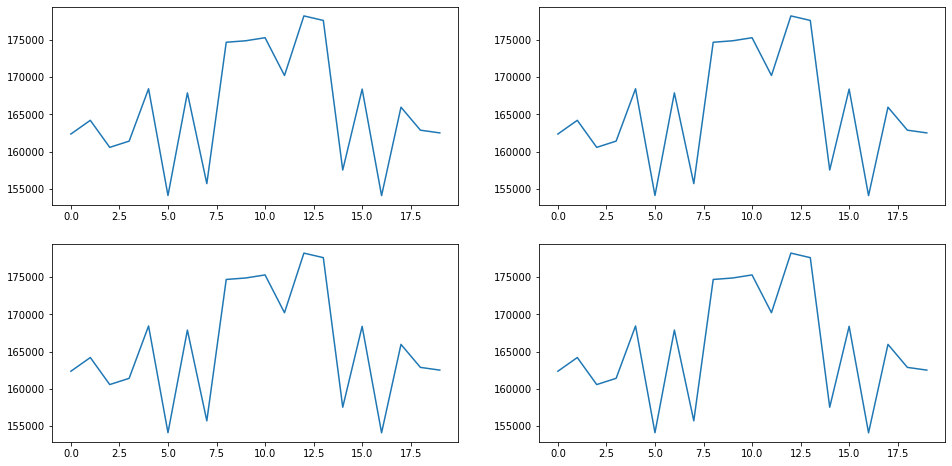

In [65]:
slide_index = list(range(20))

plt.figure(figsize=(16, 8))

plt.subplot(2,2,1)
plt.plot(slide_index, errors2_1, label = 'target 1')

plt.subplot(2,2,2)
plt.plot(slide_index, errors2_2, label = 'target 2')

plt.subplot(2,2,3)
plt.plot(slide_index, errors2_3, label = 'target 3')

plt.subplot(2,2,4)
plt.plot(slide_index, errors2_4, label = 'target 4')


plt.show()

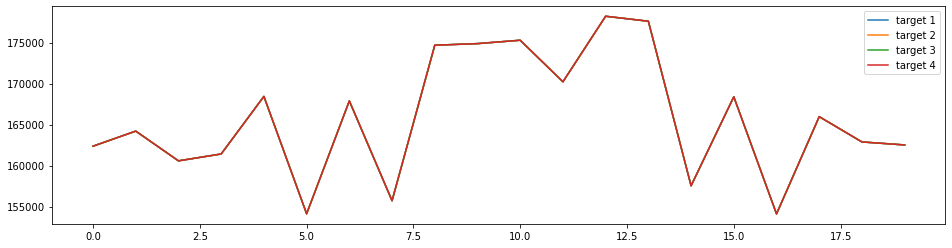

In [66]:
# Plot all errors together

plt.figure(figsize=(16, 4))
plt.plot(slide_index, errors2_1, label = 'target 1')
plt.plot(slide_index, errors2_2, label = 'target 2')
plt.plot(slide_index, errors2_3, label = 'target 3')
plt.plot(slide_index, errors2_4, label = 'target 4')

plt.legend()
plt.show()

As we studied before, the target spectrum in this program is almost zero. High error mostly due to the low resolution of target spectrum generation.

We conclude that both reconstruction and analysis are highly constrained by the sampling capability. Modifying time duration and sampling frequency to extreme high value will not lead to significant enhancement in reconstruction and analysis. Now we terminates the study of non-homogeneity and discuss how to imporve homogeneity.

# Homogeneity Enhancement by Shifting

Another attempt to generate a signal is shifting the signal and then add it to the original. We also apply time splitting for accuracy analysis. First we define a list of steps for shifting.

In [25]:
shift = [1, 2, 5, 10, 50 ,100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]

## Shift and Accuracy

In [186]:
def shift_and_accuracy(step, signal, phi, target_spectrum, num_sup):
    '''
    Input:
        step: the step for shifting
        signal: input signal
        phi: modulate phase, GSA solution
        target_spectrum: the spectrum to reconstruct for
        num_sup: the number of waves in superposition, greater than 1
    Output:
        error: the error between the reconstruction via superposition average and target spectrum
    '''
    # Initialization
    l = len(amplitude_spectrum)
    X = signal * np.exp(1j * phi)
    modulated_prime = [X[i] / num_sup for i in range(l)]
    
    
    # Shifting and Superposition
    for i in range(l):
        for j in range(int(num_sup) - 1):
            index = (i + step * j) % l
            modulated_prime[i] += X[index] / num_sup
    
    # Obtain Reconstructed Spectrum
    modulated = np.abs(np.fft.fft(modulated_prime))
    
    # Compute Error between two spectrum
    error = calculate_mse(amplitude_prime, target_spectrum)
    return error, modulated

In [187]:
# Should we expect convex morphology in resulting diagram?
# Should we optimize the number of superposition components?

errors3 = []
modulated = []

for step in shift:
    error, modulated_signal = shift_and_accuracy(step, signal_out, phi_t, amplitude_spectrum_0, 2.)
    errors3.append(error)
    modulated.append(modulated_signal)

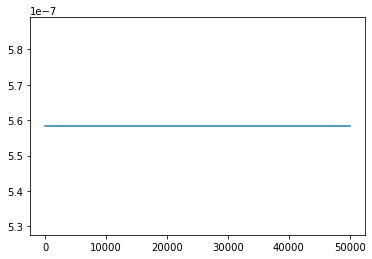

In [188]:
plt.plot(shift, errors3)

plt.show()

For different number of superposition of signal, the enhancement of reconstruction is not significant. It is resonable because we only just shift the input signal and taking average, the resulting spectrum should deviate very little to the original spectrum. However, what's the improvement of homogeneity?

## New Slides and Examination on Target Spectrum

In [189]:
# We only take 2 to 4 slides in this study for constrain of time duration and sampling frequency
c_2 = 5 * 10 ** 5 
c_4 = int(2.5 * 10 ** 5)
slides_2 = []
slides_4 = []

for i in range(2):
    a = i * c_2
    b = (i + 1) * c_2
    t_ref = t[a:b]
    slides_2.append(t_ref)
    i += 1
    
for i in range(4):
    a = i * c_4
    b = (i + 1) * c_4
    t_ref = t[a:b]
    slides_4.append(t_ref)
    i += 1

In these cases, the resolution of spectrum is

In [190]:
dt = t[1] - t[0]

w_test2 = np.fft.fftfreq(c_2, dt)
w_test3 = np.fft.fftfreq(c_4, dt)

In [191]:
print(w_test2[1] - w_test2[0])
print(w_test3[1] - w_test3[0])

7.999992
15.999984


In [192]:
# Resolution is not that bad, note that these frequencies has unit MHz

G2, _ = spectrum_generation(w_test2)
G3, _ = spectrum_generation(w_test3)

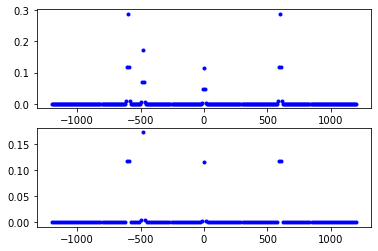

In [193]:
freq_range = (-1200, 1200)
freq_mask_1 = np.logical_and(w_test2 >= freq_range[0], w_test2 <= freq_range[1])
freq_mask_2 = np.logical_and(w_test3 >= freq_range[0], w_test3 <= freq_range[1])

plt.subplot(2, 1, 1)
plt.plot(w_test2[freq_mask_1], G2[freq_mask_1], 'b.')

plt.subplot(2, 1, 2)
plt.plot(w_test3[freq_mask_2], G3[freq_mask_2], 'b.')

plt.show()

The resolution is slightly better, now begin our analysis by slide.

## Slide and Analyze on Average Modulated Signal

For different step sizes, in 2-slide analysis, we compare the changes in error by first halves and then the second halves.

In [194]:
def slide_by_2(modulated, l, c_2):
    '''
    Input
        modulated: list contains 14 modulated signal
        l: number of steps
        c_2: number of data in each half
    Output
        two lists contain 14 lists for each half of a signal
    '''
    first_halves = []
    second_halves = []
    
    for i in range(l):
        first_halves.append(modulated[i][:c_2])
        second_halves.append(modulated[i][c_2:])
    return first_halves, second_halves

In [195]:
def data_analysis_2(target, first, second):
    first_amp = np.abs(np.fft.fft(first))
    second_amp = np.abs(np.fft.fft(second))
    
    error1 = calculate_mse(first_amp, target)
    error2 = calculate_mse(second_amp, target)
    return error1, error2

In [196]:
l = len(shift)
errors_first = []
errors_second = []

#for i in range(l):
first, second = slide_by_2(modulated, l, c_2)
#    firsts.append(first)
#    seconds.append(second)

In [197]:
el, er = data_analysis_2(G2, first[10], second[10])

In [198]:
for i in range(l):
    el, er = data_analysis_2(G2, first[i], second[i])
    errors_first.append(el)
    errors_second.append(er)

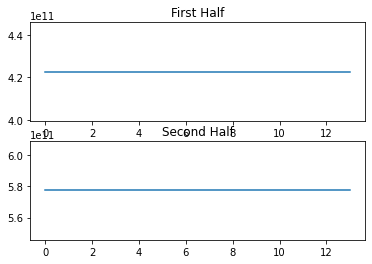

In [199]:
index = list(range(l))
plt.subplot(2,1,1)
plt.plot(index, errors_first)
plt.title("First Half")

plt.subplot(2,1,2)
plt.plot(index, errors_second)
plt.title("Second Half")

plt.show()

Seems homogeneous, but the error exploded. How's the reconstructed spectrum?

In [200]:
print(errors_first)

[422566224690.5336, 422566224690.5336, 422566224690.5336, 422566224690.5336, 422566224690.5336, 422566224690.5336, 422566224690.5336, 422566224690.5336, 422566224690.5336, 422566224690.5336, 422566224690.5336, 422566224690.5336, 422566224690.5336, 422566224690.5336]


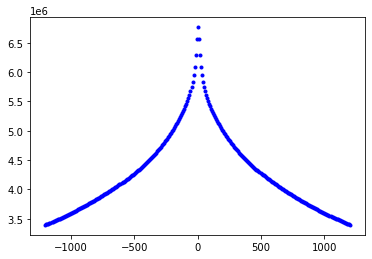

In [201]:
first_amp = np.abs(np.fft.fft(first[0]))
plt.plot(w_test2[freq_mask_1], first_amp[freq_mask_1], 'b.')

That's pretty bad. Such results also shows the constrain from sampling frequency limit and time duration. We will stop exploring this topic and begin working on the approach that concatenate the short-time solution to form a long-time solution.